<a href="https://colab.research.google.com/github/Rajesh-Nimmalapudi/Pneumonia-Detection-Using-CNN/blob/main/Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D,Conv2D,Flatten,Dense,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import zipfile
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt


In [1]:
#importing tools and libraries to set up mlflow and optuna
!pip install optuna mlflow pyngrok -q
import optuna
import mlflow
from tensorflow.keras.layers import  BatchNormalization
from pyngrok import ngrok
import time
import subprocess

SyntaxError: invalid syntax (ipython-input-1-644133765.py, line 7)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
zip_path = '/content/drive/MyDrive/archive (6).zip'  # 👈 Update if yours has a different name
extract_path = '/content/dataset'  # You can rename this

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted to:", extract_path)

✅ Dataset extracted to: /content/dataset


In [7]:
# ✅ STEP 1: Connect MLflow UI to ngrok
mlflow.set_tracking_uri("http://localhost:5000")
!mlflow ui --port 5000 &
ngrok.kill()
url = ngrok.connect(5000)
print("\n🔗 Open MLflow UI:", url)

# ✅ STEP 2: Set MLflow Experiment
mlflow.set_experiment("pneumonia_cnn_optuna")

[2025-07-16 06:33:32 +0000] [3935] [INFO] Starting gunicorn 23.0.0
[2025-07-16 06:33:32 +0000] [3935] [INFO] Listening at: http://127.0.0.1:5000 (3935)
[2025-07-16 06:33:32 +0000] [3935] [INFO] Using worker: sync
[2025-07-16 06:33:32 +0000] [3940] [INFO] Booting worker with pid: 3940
[2025-07-16 06:33:32 +0000] [3941] [INFO] Booting worker with pid: 3941
[2025-07-16 06:33:33 +0000] [3942] [INFO] Booting worker with pid: 3942
[2025-07-16 06:33:33 +0000] [3943] [INFO] Booting worker with pid: 3943
[2025-07-16 06:39:48 +0000] [3935] [INFO] Handling signal: int
[2025-07-16 06:39:48 +0000] [3940] [INFO] Worker exiting (pid: 3940)
[2025-07-16 06:39:48 +0000] [3941] [INFO] Worker exiting (pid: 3941)
[2025-07-16 06:39:48 +0000] [3942] [INFO] Worker exiting (pid: 3942)
[2025-07-16 06:39:48 +0000] [3943] [INFO] Worker exiting (pid: 3943)
[2025-07-16 06:39:49 +0000] [3935] [INFO] Shutting down: Master


ERROR:pyngrok.process.ngrok:t=2025-07-16T06:39:50+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-07-16T06:39:50+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-07-16T06:39:50+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.

In [ ]:
#paths
train_path = "/content/dataset/chest_xray/chest_xray/train"
val_path   = "/content/dataset/chest_xray/chest_xray/val"
test_path  = "/content/dataset/chest_xray/chest_xray/test"



In [6]:


train_gen = ImageDataGenerator(
    rescale = 1./255,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    rotation_range = 20
)

val_gen = ImageDataGenerator(
    rescale = 1./255
)

test_gen = ImageDataGenerator(
    rescale = 1./255
)


In [ ]:
#data generation with augumentation
train_data = train_gen.flow_from_directory(
    train_path,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'binary'

)
val_data = val_gen.flow_from_directory(
    val_path,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'binary'

)
test_data = test_gen.flow_from_directory(
    test_path,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'binary'

)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Shape of images in a batch: (32, 150, 150, 3)


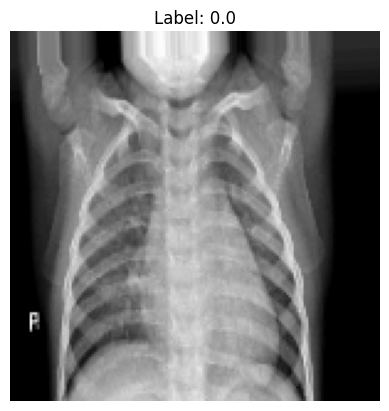

In [ ]:
# Get a batch of images and labels from the training data generator
images, labels = next(train_data)

# Print the shape of the images in the batch
print("Shape of images in a batch:", images.shape)

# Display the first image in the batch
plt.imshow(images[3])
plt.title(f"Label: {labels[3]}")
plt.axis('off')
plt.show()

In [ ]:
#cnn model
model = Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128,activation='relu'),
    Dense(64,activation='relu'),
    Dense(1,activation='sigmoid')


])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,644,673 (40.61 MB)

 Trainable params: 10,644,673 (40.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10

)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.7062 - loss: 0.6225

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 492ms/step - accuracy: 0.7065 - loss: 0.6218 - val_accuracy: 0.7500 - val_loss: 0.7276
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 436ms/step - accuracy: 0.8564 - loss: 0.3189 - val_accuracy: 0.8125 - val_loss: 0.5183
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 422ms/step - accuracy: 0.8769 - loss: 0.2780 - val_accuracy: 0.6875 - val_loss: 0.8036
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 422ms/step - accuracy: 0.8941 - loss: 0.2581 - val_accuracy: 0.6875 - val_loss: 0.6898
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 421ms/step - accuracy: 0.9115 - loss: 0.2267 - val_accuracy: 0.8125 - val_loss: 0.5131
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 443ms/step - accuracy: 0.8847 - loss: 0.2550 - val_accuracy: 0.8750 - val_loss: 0.4223
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 433ms/step - accuracy: 0.9021 - loss: 0.2279 - val_accuracy: 0.7500 - val_loss: 0.6571
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 425ms/step - accuracy: 0.9202 - loss: 0.1995 - val

In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step - accuracy: 0.9001 - loss: 0.2650
Test Accuracy: 0.90


In [ ]:
y_pred = model.predict(test_data)
y_pred = (y_pred > 0.5).astype("int32")
y_true = test_data.classes

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step
[[ 86 148]
 [130 260]]
              precision    recall  f1-score   support

           0       0.40      0.37      0.38       234
           1       0.64      0.67      0.65       390

    accuracy                           0.55       624
   macro avg       0.52      0.52      0.52       624
weighted avg       0.55      0.55      0.55       624

